In [121]:
import torch
import pandas as pd
import tqdm
import re
import numpy as np
from datasets import load_dataset, load_from_disk
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from sklearn.metrics import classification_report


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cuda


In [3]:
dataset = load_dataset("imdb")

In [5]:
df = dataset['train'].to_pandas()

In [7]:
df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


<Axes: xlabel='label'>

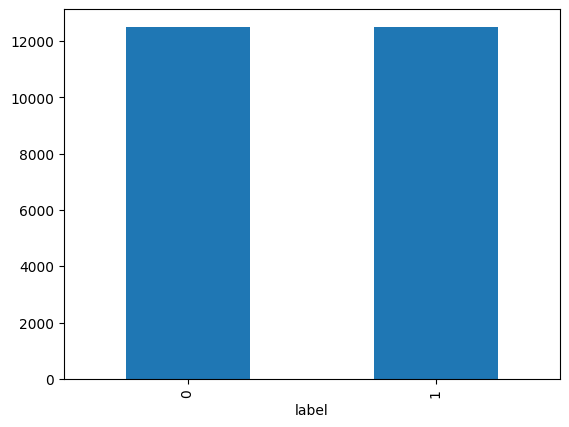

In [11]:
df["label"].value_counts().plot(kind="bar")

In [12]:
phrase_length = df["text"].apply(len).value_counts()

<Axes: ylabel='Frequency'>

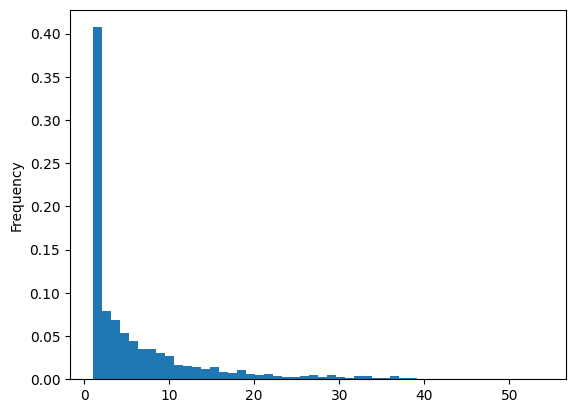

In [13]:
phrase_length.plot(kind="hist", bins=50, density=True)

In [83]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(batch):
    cleaned_texts = []
    for text in batch["text"]:
        text = text.lower()
        text = re.sub(r"[^a-z\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        cleaned_texts.append(text)
    return {"text": cleaned_texts, "label": batch["label"]}

def encode_batch(batch):
    cleaned = [clean_text(t) for t in batch["text"]]  # or your cleaner
    embeddings = model.encode(cleaned, convert_to_tensor=False)
    batch["embedding"] = [emb.tolist() for emb in embeddings]
    return batch


model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

cache_dir = Path("data")
train_cache = cache_dir / "imdb_train_encoded"
test_cache = cache_dir / "imdb_test_encoded"
val_cache = cache_dir / "imdb_val_encoded"


if train_cache.exists() and test_cache.exists():
    train_encoded = load_from_disk(train_cache.as_posix())
    test_encoded = load_from_disk(test_cache.as_posix())
    val_encoded = load_from_disk(val_cache.as_posix())
else:
    cache_dir.mkdir(parents=True, exist_ok=True)
    split_dataset = dataset["test"].train_test_split(test_size=0.5, seed=42)
    val_dataset = split_dataset["train"]
    test_dataset = split_dataset["test"]

    train_encoded = dataset['train'].map(encode_batch, batched=True, batch_size=64)
    test_encoded = test_dataset.map(encode_batch, batched=True, batch_size=64)
    val_encoded = val_dataset.map(encode_batch, batched=True, batch_size=64)

    train_encoded.save_to_disk(train_cache.as_posix())
    test_encoded.save_to_disk(test_cache.as_posix())
    val_encoded.save_to_disk(val_cache.as_posix())

for split in (train_encoded, val_encoded, test_encoded):
    split.set_format(type="torch", columns=["embedding", "label"])


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12500 [00:00<?, ? examples/s]

In [84]:

common_generator = torch.Generator(device=device)

test_loader = DataLoader(test_encoded, batch_size=32, shuffle=True, generator=common_generator)
val_loader = DataLoader(val_encoded, batch_size=32, shuffle=False, generator=common_generator)
train_loader = DataLoader(train_encoded, batch_size=32, shuffle=True, generator=common_generator)

In [85]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(embedding_dim, 128)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.sigmoid(logits)
            return (probs >= 0.5).float()


In [127]:
def train(model, train_dataloader, val_dataloader, epochs, criterion, optimizer):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm.tqdm(train_dataloader):
            embeddings = batch["embedding"].to(device)
            labels = batch["label"].view(-1, 1).to(device).float()

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_dataloader)
        val_accuracy = evaluate(model, val_dataloader, criterion)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


def evaluate(model, dataloader, criterion):
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            embeddings = batch["embedding"].to(device)
            labels = batch["label"].view(-1, 1).to(device).float()

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(dataloader)



def test(model, dataloader):
    y_preds = np.array([])
    y_trues = np.array([])
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            embeddings = batch["embedding"]
            labels = batch["label"].view(-1, 1).to(device).float()

            y_pred = torch.sigmoid(model(embeddings)).long()
            y_preds = np.append(y_preds, y_pred.squeeze().cpu().numpy())
            y_trues = np.append(y_trues, labels.squeeze().cpu().numpy())

    print(y_preds)
    print(y_trues)
    return classification_report(y_trues, y_preds, target_names=["negative", "positive"])

In [81]:
clf = SentimentClassifier(model.get_sentence_embedding_dimension()).to(device)

In [123]:
train(clf, train_loader, val_loader, epochs=5, 
      criterion=torch.nn.BCEWithLogitsLoss(), 
      optimizer=torch.optim.Adam(clf.parameters(), lr=1e-3))

100%|██████████| 782/782 [00:04<00:00, 176.61it/s]


Epoch 1/5, Loss: 0.3459, Val Accuracy: 0.3997


100%|██████████| 782/782 [00:04<00:00, 182.28it/s]


Epoch 2/5, Loss: 0.3374, Val Accuracy: 0.3807


100%|██████████| 782/782 [00:04<00:00, 173.35it/s]


Epoch 3/5, Loss: 0.3286, Val Accuracy: 0.3787


100%|██████████| 782/782 [00:04<00:00, 194.76it/s]


Epoch 4/5, Loss: 0.3197, Val Accuracy: 0.3845


100%|██████████| 782/782 [00:04<00:00, 180.87it/s]


Epoch 5/5, Loss: 0.3109, Val Accuracy: 0.3827


In [129]:
print(test(clf, test_loader))

[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 1. 1. 0.]
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67      6267
    positive       0.00      0.00      0.00      6233

    accuracy                           0.50     12500
   macro avg       0.25      0.50      0.33     12500
weighted avg       0.25      0.50      0.33     12500



/home/felix/repo/ml-laby/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felix/repo/ml-laby/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felix/repo/ml-laby/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}